In [1]:
## Created by Wentinn Liao

# CS180 Project 1

In [42]:
!pip install numpy imageio scikit-learn scikit-image torch pytorch-ignite matplotlib

In [3]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
#@title Symlink Setup
def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/CS180/HW1'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/HW1'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH

In [5]:
%cd $SYM_PATH

/content/gdrive/My Drive/CS180/HW1


In [6]:
#@title Configure Jupyter Notebook
%load_ext autoreload
%autoreload 2

In [43]:
#@title Library Setup
import os
import time
import json
import math
import functools
import numpy as np
import scipy as sc
import skimage as sk
import skimage.io as skio
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import *
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from ignite.contrib import metrics as M
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

seed = 7
torch.manual_seed(seed)
random.seed(seed)
torch.set_default_dtype(torch.double)

# Implementation

In [8]:
#@title Utilities
def read_image(imname: str) -> np.ndarray:
    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)
    im = sk.util.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2 * height]
    r = im[2 * height: 3 * height]

    return np.stack([r, g, b])

def im_to_uint8(im: np.ndarray) -> np.ndarray:
    return np.floor(256 * im).astype('u1')

In [9]:
#@title Transforms
def histogram_transform(im: np.ndarray) -> np.ndarray:
    result = []
    for channel in im:
        flattened_channel = channel.flatten()
        flattened_transform = np.searchsorted(np.sort(flattened_channel), flattened_channel, side='right') / len(flattened_channel)
        result.append(np.reshape(flattened_transform, channel.shape))
    return np.array(result)

def reduce_transform(im: np.ndarray, scale: int=1) -> np.ndarray:
    for _ in range(scale):
        im = im[:, :(im.shape[1] >> 1) << 1, :(im.shape[2] >> 1) << 1]
        im = (im[:, 0::2, 0::2] + im[:, 1::2, 0::2] + im[:, 0::2, 1::2] + im[:, 1::2, 1::2]) / 4
    return im

def edge_transform(im: np.ndarray, s=1) -> np.ndarray:
    sobel_vertical = np.array([[i / (i * i + j * j) if (i != 0 and j != 0) else 0 for i in range(-s, s + 1)] for j in range(-s, s + 1)])
    sobel_horizontal = sobel_vertical.T

    edge_vertical = np.stack([sc.signal.convolve2d(channel, sobel_vertical, mode='valid') for channel in im])
    edge_horizontal = np.stack([sc.signal.convolve2d(channel, sobel_horizontal, mode='valid') for channel in im])

    edge = np.linalg.norm(np.stack([edge_vertical, edge_horizontal]), axis=0)
    edge_min, edge_max = np.min(edge), np.max(edge)

    return F.sigmoid(torch.DoubleTensor(5 * (edge - 0.5 * (edge_min + edge_max)) / (edge_max - edge_min))).numpy()

In [51]:
from ast import Return
#@title Image Alignment
def align_displacement(im1: np.ndarray, im2: np.ndarray, cx: int, cy: int, window: int):
    w, h = im1.shape

    max_corr, max_dx, max_dy = 0, None, None
    for dx in range(cx - window, cx + window + 1):
        for dy in range(cy - window, cy + window + 1):
            cropped_im1 = im1[max(0, dx):w + min(0, dx), max(0, dy):h + min(0, dy)]
            cropped_im2 = im2[max(0, -dx):w + min(0, -dx), max(0, -dy):h + min(0, -dy)]

            corr = np.sum(cropped_im1 * cropped_im2)
            if corr > max_corr:
                max_corr, max_dx, max_dy = corr, dx, dy

    return max_dx, max_dy


def align_helper(im: np.ndarray, max_size: int, base_window: int, decay: float):
    if im.shape[1] > max_size and im.shape[2] > max_size:
        im = im[:, :(im.shape[1] >> 1) << 1, :(im.shape[2] >> 1) << 1]
        reduced_im = (im[:, 0::2, 0::2] + im[:, 1::2, 0::2] + im[:, 0::2, 1::2] + im[:, 1::2, 1::2]) / 4
        center_d, window = align_helper(reduced_im, max_size, base_window, decay)

        center_d *= 2
        window = int(math.ceil(window * decay))
    else:
        center_d, window = np.zeros((3, 2), dtype=int), base_window

    e = edge_transform(histogram_transform(im))
    w, h = e.shape[1:]

    d = np.array([align_displacement(e[i], e[i - 2], *center_d[i], window) for i in range(3)])

    max_corr, max_d = 0, None
    for i in range(3):
        d_i = np.roll(np.stack([np.array([0, 0]), d[i], -d[i - 1]]), i, axis=0)
        crop_x_min, crop_y_min = np.max(d_i, axis=0)
        crop_x_max, crop_y_max = np.min(d_i, axis=0) + e.shape[1:]

        crop_x = np.arange(crop_x_min, crop_x_max)
        crop_y = np.arange(crop_y_min, crop_y_max)

        aligned_edge_im = np.array([e[j, crop_x - d_i[j, 0]][:, crop_y - d_i[j, 1]] for j in range(3)])
        corr = np.sum(np.prod(aligned_edge_im, axis=0))

        if corr > max_corr:
            max_corr = corr
            max_d = np.roll(np.stack([d[i], -(d[i] + d[i - 1]), d[i - 1]]), i, axis=0)

    return max_d, window


def align(imname: str, k: int=30, max_size: int=600, window: int=40, decay: float=0.5):
    im = read_image(imname)
    if k > 0:
        c = int(im.shape[1] * k / max_size)
        im = im[:, c:-c, c:-c]

    d, _ = align_helper(im, max_size, window, decay)
    d0 = np.stack([np.array([0, 0]), d[0], -d[-1]])

    crop_x_min, crop_y_min = np.max(d0, axis=0)
    crop_x_max, crop_y_max = np.min(d0, axis=0) + im.shape[1:]

    crop_x = np.arange(crop_x_min, crop_x_max)
    crop_y = np.arange(crop_y_min, crop_y_max)

    return np.transpose(np.array([im[j, crop_x - d0[j, 0]][:, crop_y - d0[j, 1]] for j in range(3)]), (1, 2, 0)), d


[[-7 -1]
 [-5 -2]
 [12  3]]


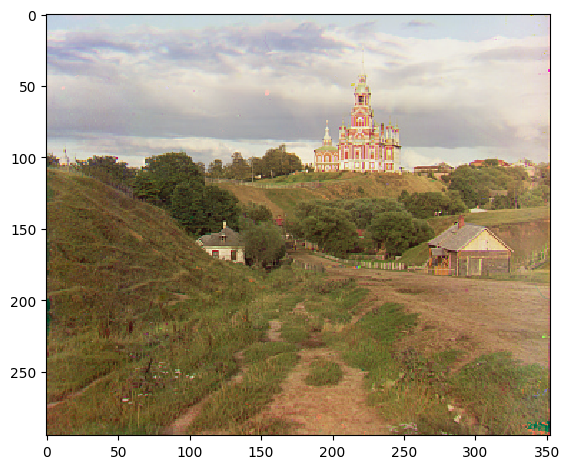

[[-33   8]
 [-25  -4]
 [ 58  -4]]


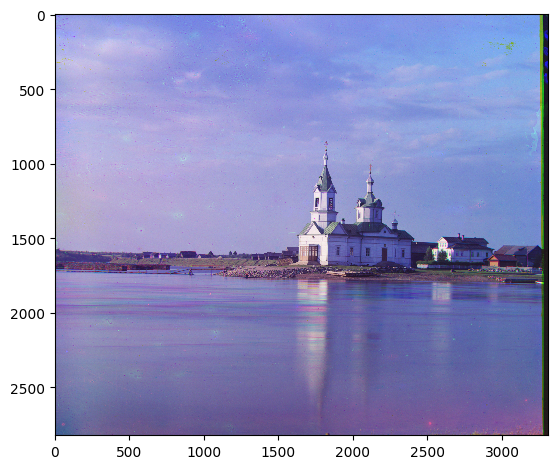

[[-58 -17]
 [-49 -24]
 [107  41]]


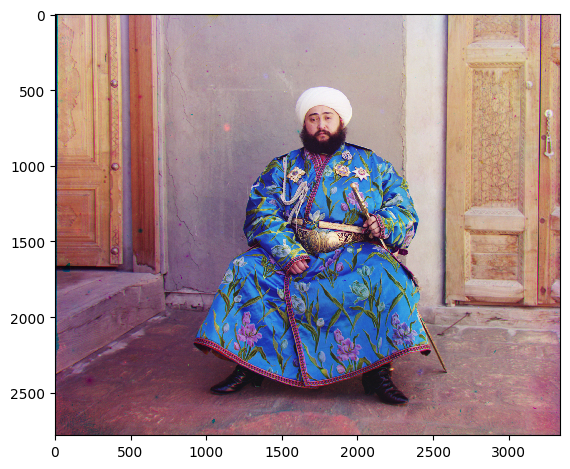

In [ ]:
images = [
    'cathedral.jpg',
    'church.tif',
    'emir.tif',
    'harvesters.tif',
    'icon.tif',
    'lady.tif',
    'melons.tif',
    'monastery.jpg',
    'onion_church.tif',
    'sculpture.tif',
    'self_portrait.tif',
    'three_generations.tif',
    'tobolsk.jpg',
    'train.tif'
]

for imname in images:
    aligned_im, displacement = align('data/' + imname)

    skio.imsave('output/' + imname, im_to_uint8(aligned_im))

    print(displacement)
    skio.imshow(aligned_im)
    skio.show()